# Quantum Variational Classifier
## Is it a fern-like fractal?

OK, so, I wanted to play around with some quantum machine learning, but I didn't want to repeat the use of the same old functions and datasets. Walking around San Francisco, I had the idea to do something with simple tree-like fractals.

One of the first and best known is [Michael Barsley's fern](https://en.wikipedia.org/wiki/Barnsley_fern) from the 1980s. It starts by placing a dot at the origin and then repeatedly, randomly chooses one of 4 ways to move to another coordinate and draws a dot there. Each of the 4 potential moves is defined by a simple affine transform, and each happens with a predefined probability. The 24 parameters of the affine transformations define the overall shape that emerges after you draw enough dots.

/Users/zac/code/qml-fern-fractal/venv/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


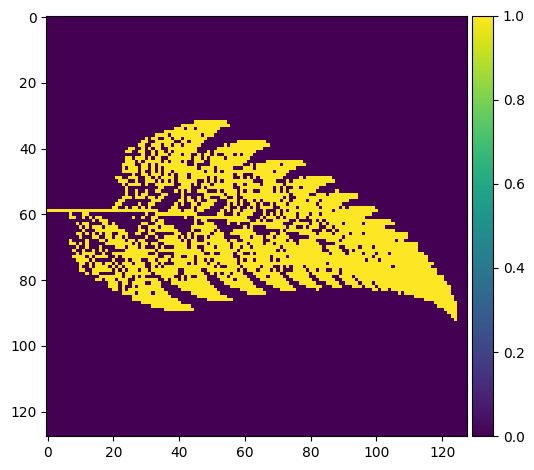

In [1]:
from pennylane import numpy as np
from skimage.io import imshow

rng = np.random.default_rng()

class BarnsleyFern:
    canonical_params = [[ 0.00,  0.00,  0.00, 0.16, 0.0, 0.00],
                        [ 0.85,  0.04, -0.04, 0.85, 0.0, 1.60],
                        [ 0.20, -0.26,  0.23, 0.22, 0.0, 1.60],
                        [-0.15,  0.28,  0.26, 0.24, 0.0, 0.44]]

    def __init__(self, params=canonical_params, prob_thresholds=[0.01, 0.86, 0.93], size=128):
        """Params is a 2D list (4 lists of 6 floats), defining the 4 affine transforms.
        The probability thresholds define how often each transform is chosen.
        Size determines the length of one side of the square output array.
        See https://en.wikipedia.org/wiki/Barnsley_fern
        """
        self.params = params
        self.prob_thresholds = prob_thresholds
        self.size = size
        
    def generate(self):
        a = np.zeros((self.size, self.size), dtype=np.byte)
        x, y = 0.0, 0.0
        for n in range(10000):
            self._mark(a, x, y)
            x, y = self._transform(x, y)
        return a

    def _mark(self, a, x, y):
        pixel_x, pixel_y = self._fit_canvas(x, y)
        a[pixel_x, pixel_y] = 1

    def _fit_canvas(self, x, y):
        scale = 0.097
        x_scaled = (x * scale + 0.46) * self.size
        y_scaled = y * scale * self.size
        return self._round_and_clip(x_scaled), self._round_and_clip(y_scaled)

    def _round_and_clip(self, val):
        clipped = min(max(val, 0), self.size-1)
        try:
            return int(np.around(clipped))
        except:
            return 0

    def _transform(self, x, y):
        r = rng.random()
        if r < self.prob_thresholds[0]:
            return self._chosen_transform(0, x, y)
        elif r < self.prob_thresholds[1]:
            return self._chosen_transform(1, x, y)
        elif r < self.prob_thresholds[2]:
            return self._chosen_transform(2, x, y)
        else:
            return self._chosen_transform(3, x, y)
    
    def _chosen_transform(self, t, x, y):
        p = self.params[t]
        x_next = p[0] * x + p[1] * y + p[4]
        y_next = p[2] * x + p[3] * y + p[5]
        return x_next, y_next

fern = BarnsleyFern()
f1 = fern.generate()
f2 = fern.generate()
imshow(f1)

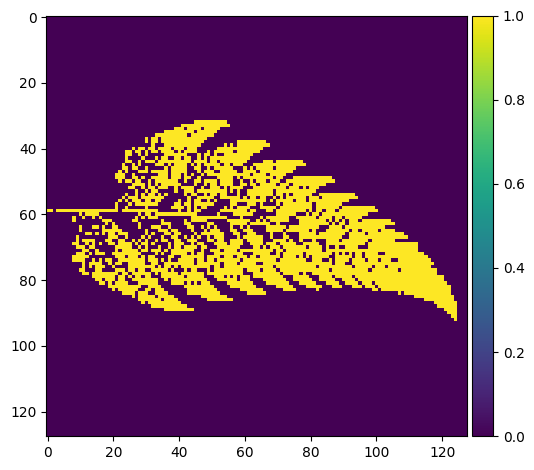

In [2]:
imshow(f2)

I started playing around with the parameters to get a feel for the boundaries of what I could change before the shape didn't look much like the original fern anymore. The first thing I did was see what appeared if all the parameters were random. The answer: splatters or sparse nothingness.

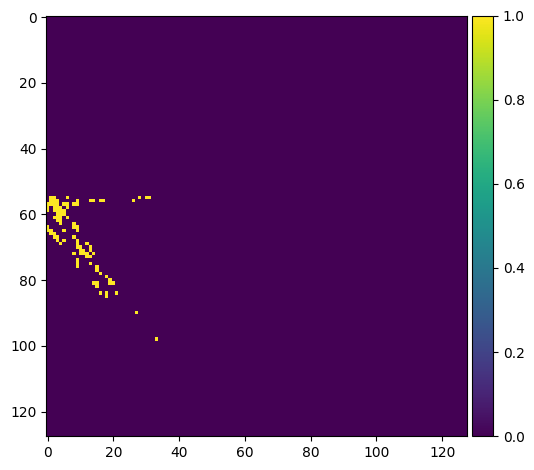

In [3]:
random_fern = BarnsleyFern(1.3*rng.random((4,6))-0.3)
frand1 = random_fern.generate()
frand2 = random_fern.generate()
imshow(frand1)

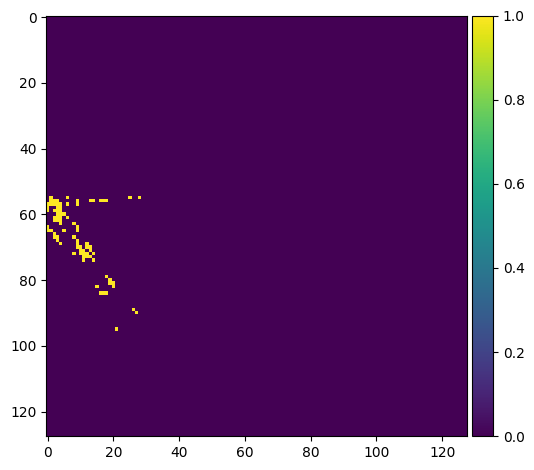

In [4]:
imshow(frand2)

OK, so then what if I keep most of the parameters using Barnsley's canonical values and just change 4 of them?

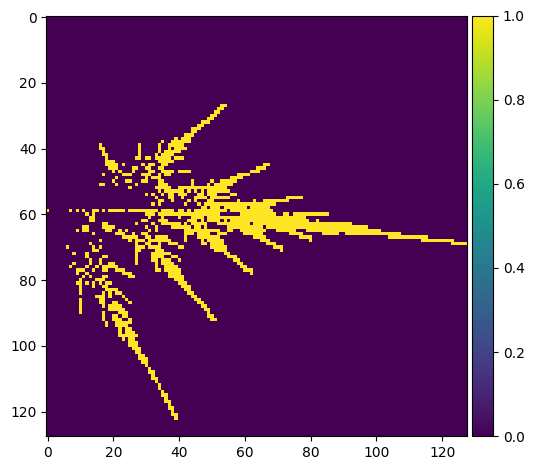

In [5]:
almost = np.copy(BarnsleyFern.canonical_params)
almost[1][0] = 0.5
almost[3][1] = 0.5
almost[2][2] = 0.5
almost[0][3] = 0.5

learnable_fern = BarnsleyFern(almost)
lf1 = learnable_fern.generate()
lf2 = learnable_fern.generate()
imshow(lf1)

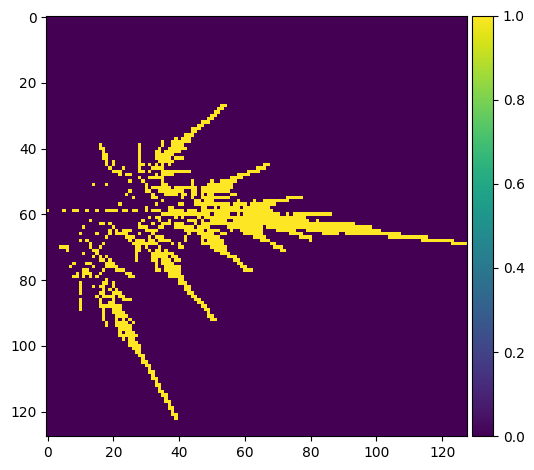

In [6]:
imshow(lf2)

Not bad. Not bad. Spiky. Almost a leaf. We'll start there.

Let's use QML to learn to recognize the Barnsley Fern, varying those 4 parameters as inputs.

## Pick a toolset and approach, take 1

At first I was going to use [TensorFlow Quantum](https://www.tensorflow.org/quantum). After going through a quick tutorial using Google Colab, I started setting up a local workspace, and... womp, womp — I'm running macOS 13, and [the `tensorflow-quantum` package](https://pypi.org/project/tensorflow-quantum/0.7.2/#files) only supports macOS 12 at the moment.

I could probably get it running on docker or a VM, but for now I'll just try something else.

### Toolset, take 2

OK, then how about [Pennylane](https://pennylane.ai/)? Yep. Easy peasy. From here on out I'll be doing a variation of [their Variational Classifier demo](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html).

## Generate Some Data

Time to craft a dataset. The input samples will be random values between zero and one for four of the Barnsley fern parameters. The output label will be 1 if the input parameters generate something that looks reasonably fern-like, or -1 if not. The goal is for the classifier to learn to predict whether the given parameters will look fern-like or not.

If you're running this notebook, you can play with the paramters in the cell below.

The data file I came up with is in this repo as samples.txt.

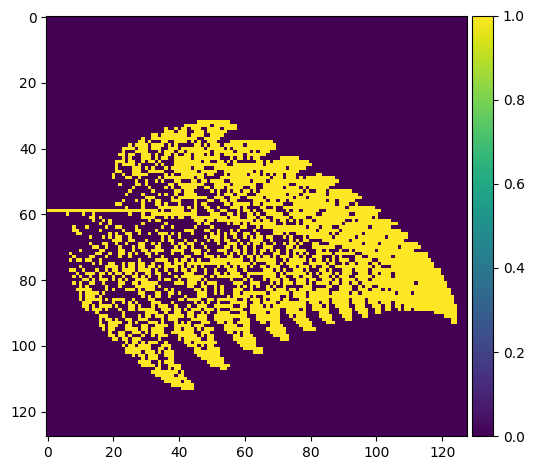

In [7]:
zp = np.copy(BarnsleyFern.canonical_params)

# Play with these 4 parameters.
# The values in comments usually generate something fern-like.

zp[1][0] = 0.85482 # 0.73-0.93
zp[3][1] = 0.47245 # 0.23-0.58
zp[2][2] = 0.29501 # 0.10-0.60
zp[0][3] = 0.17148 # 0.14-0.20

zf = BarnsleyFern(zp)
za = zf.generate()
imshow(za)

## State Preparation

The input samples need to be encoded into a quantum state. We can encode 4 real numbers onto a 2-qubit state.

For this first pass I'll just stick to the approach in the Pennylane demo, based on papers from 2004 and 2018. I'm guessing that a more naive encoding would work fine; maybe I'll test that assumption in another iteration.

Using the Möttönen/Schuld/Petruccione method, we'll translate the 4 features of our input samples into 5 angles for Y-rotation gates.

In [8]:
import pennylane as qml

def get_angles(x):
    """From Schuld and Petruccione (2018).
    See https://pennylane.ai/qml/demos/tutorial_variational_classifier.html
    """
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

The weights that the optimizer will actually tune will be for several layers of arbitrary qubit rotations with an entangling CNOT.

In [9]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

The expectation value of the first qubit will be the output, predicting whether or not those parameters generate a fern fractal. That's all we need from the quantum circuit. 👍

In [10]:
dev = qml.device("default.qubit", wires=2)    

@qml.qnode(dev)
def circuit(weights, angles):
    state_preparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

Let's load the data and see what the first sample looks like when translated into angles for state preparation.

In [11]:
data = np.loadtxt("samples.txt")
X = data[:, 0:4]
print("First X sample             :", X[0])

# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Y = data[:, -1]

First X sample             : [0.17057 0.80132 0.13754 0.21703]
First X sample (normalized): [0.19865614 0.93326574 0.1601874  0.25276627]
First features sample      : [ 0.60781387 -1.00593869  1.00593869 -1.36106529  1.36106529]


And now let's draw an example circuit with only 2 layers. We'll use more when optimizing.

In [12]:
# Draw an example circuit with 2 layers
print(qml.draw(circuit)(rng.random((2, 2, 3)), features[0]))

0: ──RY(0.61)─╭●────────────╭●──X────────╭●────────────╭●──X─────────Rot(0.24,0.39,0.56)─╭●
1: ───────────╰X──RY(-1.01)─╰X──RY(1.01)─╰X──RY(-1.36)─╰X──RY(1.36)──Rot(0.68,0.40,0.57)─╰X

───Rot(0.36,0.53,0.14)─╭●─┤  <Z>
───Rot(0.31,0.20,0.88)─╰X─┤     


## Variational Classifier

Now it's time to use an optimizer to tune the layers of entangled rotations. We need to run the circuit to generate each prediction, and we need a cost function to enable gradient descent. We'll also define an accuracy function to monitor how the optimizer is improving as it runs.

In [13]:
def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            acc += 1
    return acc / len(labels)

def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

And of course we always have to separate our data into training and validation sets, to test the classifier on data it hasn't seen before.

In [14]:
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

Let's go! We'll start with random weights close to zero, use 6 layers of entangled rotations, and iterate 60 times on batches of 5 samples.

In [15]:
%%time

from pennylane.optimize import NesterovMomentumOptimizer

num_qubits = 2
num_layers = 6

weights_init = 0.01 * rng.standard_normal(size=(num_layers, num_qubits, 3), requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
weights = weights_init
bias = bias_init

for it in range(60):

    # Update the weights by one optimizer step
    batch_index = rng.integers(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    (weights, bias, _, _), last_cost = opt.step_and_cost(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on the training and validation sets
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on the training and validation sets
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, last_cost, acc_train, acc_val)
    )

Iter:     1 | Cost: 0.5142687 | Acc train: 0.6693333 | Acc validation: 0.6880000 
Iter:     2 | Cost: 0.8055910 | Acc train: 0.7324444 | Acc validation: 0.7466667 
Iter:     3 | Cost: 0.7521793 | Acc train: 0.7813333 | Acc validation: 0.7840000 
Iter:     4 | Cost: 0.9609906 | Acc train: 0.8524444 | Acc validation: 0.8426667 
Iter:     5 | Cost: 0.7957466 | Acc train: 0.8800000 | Acc validation: 0.8746667 
Iter:     6 | Cost: 0.5307140 | Acc train: 0.8711111 | Acc validation: 0.8800000 
Iter:     7 | Cost: 1.0116025 | Acc train: 0.8355556 | Acc validation: 0.8426667 
Iter:     8 | Cost: 0.8416337 | Acc train: 0.7786667 | Acc validation: 0.8053333 
Iter:     9 | Cost: 0.4999476 | Acc train: 0.7555556 | Acc validation: 0.7813333 
Iter:    10 | Cost: 0.2219851 | Acc train: 0.7431111 | Acc validation: 0.7680000 
Iter:    11 | Cost: 0.8473893 | Acc train: 0.7768889 | Acc validation: 0.8080000 
Iter:    12 | Cost: 0.4822734 | Acc train: 0.8382222 | Acc validation: 0.8320000 
Iter:    13 | Co

## Plot what we learned

Here are a couple plots that show the 2 classes, one of the first 2 features and another along the last 2 features.

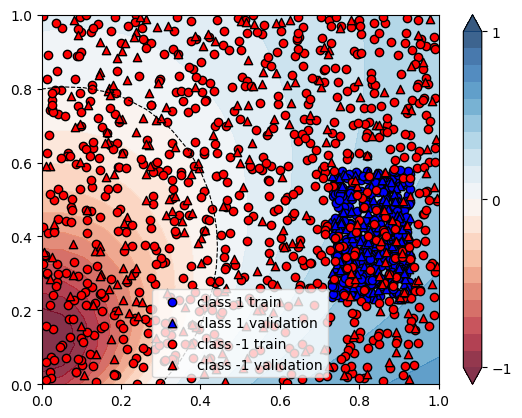

In [16]:
import matplotlib.pyplot as plt

plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.0, 20), np.linspace(0.0, 1.0, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

padding1 = 0.23 * np.ones((len(X_grid), 1))
padding2 = 0.16 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding1], padding2]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot the first 2 features
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

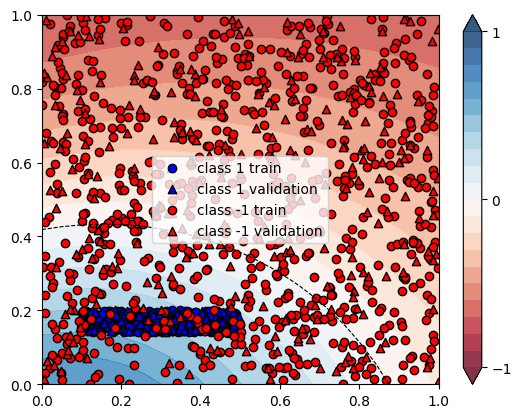

In [17]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.0, 20), np.linspace(0.0, 1.0, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

padding1 = 0.85 * np.ones((len(X_grid), 1))
padding2 = 0.28 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[padding1, padding2], X_grid]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot the last 2 features
plt.scatter(
    X_train[:, 2][Y_train == 1],
    X_train[:, 3][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 2][Y_val == 1],
    X_val[:, 3][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 2][Y_train == -1],
    X_train[:, 3][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 2][Y_val == -1],
    X_val[:, 3][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()